# Analyze experiments
Run the post-processing needed to compare different runs.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from shutil import rmtree
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import json

Configuration

In [2]:
run_dir = Path('prod-runs/8KNL-8V100-continuous/')
run_dir = Path('../runs/xtb-N8-n1-022ad4-14May22-195832')

## Load in the Results
We want the runtimes and system hostnames so we can measure how many tasks are running concurrently

In [3]:
def load_results(path: Path) -> pd.DataFrame:
    """Load the results for a certain run
    
    Args:
        path: Path to the run
    Returns:
        Dataframe of all results
    """
    
    # Loop over inference, training, and simulation
    output = []
    for task in ['inference', 'training', 'simulation']:
        # Get the results
        data = path / f'{task}-results.json'
        assert data.is_file(), f'{data} does not exist'
        results = pd.read_json(path / f'{task}-results.json', lines=True)
        
        # Store make some metadata easier to get
        results['task'] = task
        results['hostname'] = results['worker_info'].apply(lambda x: x.get('hostname', 'nidXXXXX') if x is not None else 'nidXXXXX')
        
        # Mark the machine running
        def _get_machine(hostname):
            if hostname.startswith('lambda'):
                return 'lambda'
            elif hostname.startswith('nid'):
                return 'theta'
            elif hostname.startswith('thetagpu'):
                return 'thetagpu'
            elif hostname.startswith('venti'):
                return 'venti'
            else:
                raise ValueError(f'Unknown host: {hostname}')
        results['machine'] = results['hostname'].apply(_get_machine)
                
        # Make a shorter name for the task type
        def _get_task(method):
            if method.endswith('simulation'):
                return 'simulation'
            elif method.startswith('evaluate'):
                return 'inference'
            else:
                return 'training'
        
        results['task_type'] = results['method'].apply(_get_task)
        output.append(results)
        
    # Return sorted by 
    output = pd.concat(output)
    output.sort_values('time_compute_started', inplace=True, ignore_index=True)
    return output

In [4]:
results = load_results(run_dir)

## Plot the Utilization over Time
Without factoring out queue times.

First step is to mark when the utilization changes (at the beginning and end of jobs)

In [5]:
def get_utilization_over_time(results: pd.DataFrame) -> pd.DataFrame:
    """Get the utilization of all machines over time.
    
    Args:
        results: Result data for all tasks
    Returns:
        Utilization of each system over time
    """
    
    # Store the times at which tasks begin or end
    steps = []
    for rid, task in results.iterrows():
        for t, c in zip([task['time_compute_started'], 
                         task['time_compute_started'] + task['time_async_resolve_proxies'] + task['time_deserialize_inputs'] + task['time_running'] + task['time_serialize_results']],
                        [1, -1]):
            steps.append({
                'task_type': task['task_type'],
                'timestamp': t,
                'machine': task['machine'],
                'hostname': task['hostname'],
                'change': c
            })
    
    # Sort by timestamp
    steps = pd.DataFrame(steps)
    steps.sort_values('timestamp', inplace=True, ignore_index=True)
    
    # Normalize the walltimes for the results and the 
    steps['walltime'] = steps['timestamp'] - steps['timestamp'].min()
    results['walltime'] = results['time_result_received'] - steps['timestamp'].min()
    
    # Get the utilization for machine and by task
    machines = set(steps['machine'])
    task_types = set(steps['task_type'])
    total_used = dict((x, 0) for x in list(machines) + list(task_types))
    utilization = []
    for rid, row in steps.iterrows():
        total_used[row['machine']] += row['change']
        total_used[row['task_type']] += row['change']
        utilization.append(total_used.copy())
    utilization = pd.DataFrame(utilization)
    utilization['total'] = utilization[machines].sum(axis=1)
    
    # Append it to the tracking
    utilization = pd.concat((steps, utilization), axis=1)
    
    return utilization

In [6]:
utilization = get_utilization_over_time(results)

Factor out the idle times (due to jobs waiting in queue)

In [7]:
def remove_queue_times(utilization: pd.DataFrame, results: pd.DataFrame, minimum_span=60):
    """Remove the times the system was stuck waiting for nodes to be available
    
    Args:
        utilization: Dataframe containing the utilization over time
        results: Dataframe containing the task information
        minimum_span: Minimum time to declare a utilization absence due to queues
    """
    
    # Get the times where the system is completely idle
    stop_use = utilization.query('total==0').index[0:-1]  # Last one is shutdown
    
    # Find those where the downtime is honger than the minimum span
    is_longer = (utilization.loc[stop_use + 1, 'walltime'].values - utilization.loc[stop_use, 'walltime']) > minimum_span
    queue_stops = stop_use[is_longer]
    
    # Compute the time spent in queue for each pause
    queue_times = utilization.loc[queue_stops + 1, 'walltime'].values - utilization.loc[queue_stops, 'walltime']
    
    # Remove that time from jobs that occur after each time
    queue_starts = utilization.loc[queue_stops, 'walltime']
    for frame in (utilization, results):
        frame['time_queueing'] = 0
        for queue_start, queue_time in zip(queue_starts, queue_times):
            frame.loc[frame['walltime'] > queue_start, 'time_queueing'] += queue_time
        
        frame['walltime'] -= frame['time_queueing']
remove_queue_times(utilization, results)

Plot by the machine and task type

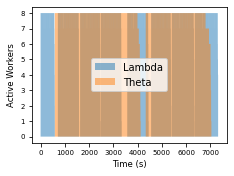

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for machine in set(results['machine']):
#    if machine != "thetagpu": continue
    ax.fill_between(utilization['walltime'], utilization[machine], step='post', label=machine.capitalize(), alpha=0.5)

#ax.set_xlim(0, 100)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Active Workers')

ax.legend(loc='center')
fig.savefig('figures/theta-utilization.png', dpi=320)

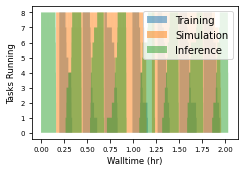

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

for task_type in set(results['task_type']):
    ax.fill_between(utilization['walltime'] / 3600, utilization[task_type], step='post', label=task_type.capitalize(), alpha=0.5)

#ax.set_xlim(0, 0.75)
#ax.set_ylim(0, 8)


ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('Tasks Running')

ax.legend()
fig.tight_layout()

## Compute System Utilization
We are targeting HPC systems where nodes are allocated in blocks. That means you get charged for the full block regardless of how many jobs are running. 

The following function computes the resource costs under this condition

In [10]:
def compute_cost(utilization: pd.DataFrame, results: pd.DataFrame, idletime: float = 60): 
    """Compute the charge from a supercomputer center based on utilization
    
    We get charged for ll nodes enven if you're not using them.
    
    Args:
        utilization: Dataframe containing the utilization over time
        results: Dataframe containing 
        idletime: How long to wait before halting charges on a ndoe
    """
    # Process each machine separately
    for machine, group in utilization.groupby('machine'):
        # Mark the points idletime after the machine just became idle
        ref_points = group[np.all(np.stack([
            group.change < 0,
            group[machine] == 0,
            np.logical_not(group.walltime.isnull())
        ], axis=1), axis=1)].timestamp + idletime
        
        # Combine these with the points where the machine had at least one task
        #  to determine the "Active Spans" where there has been an unbroken time
        #  between when the machine was active with brakes smaller than the overall
        active_starts = group[np.logical_and(
            group[machine] > 0,
            np.logical_not(group.walltime.isnull())
        )].timestamp
        active_times = np.sort(np.hstack([active_starts, ref_points]))
        
        # Find the points where the times between an "active" point is greater than the idletime
        #  These are where a job started.
        elapsed = np.diff(active_times)
        start_points = np.where(elapsed > idletime)[0] + 1
        
        # Get the time where the last job ended
        end_points = start_points - 1
        
        # Record these spans knowning that the first activity period started at the first point
        #  and the last active period ended at the last actiity time
        spans = list(zip(active_times[start_points],
                         active_times[end_points[1:]]))
        spans.insert(0, (active_times[0], active_times[end_points[0]]))
        spans.append((active_times[start_points[-1]], active_times[-1]))
        
        # Sort by the time 
        spans = np.array(spans)
        assert np.all(spans[1:, 0] >= spans[:-1, 1])
        assert np.all(np.diff(spans[:, 0]) > 0)
        assert np.all(spans[:, 1] >= spans[:, 0]), spans[:, 1] - spans[: , 0]
        
        # Use these to compute the amount of elapsed resource utilization for each result
        node_count = group[machine].max()
        def _get_time_used(x: float) -> float:
            """Get the amount of compute used up to a certain point"""
            output = 0
            
            # If the compute hasn't been used yet
            if x < spans[0][0]:
                return 0
            
            # Add up from all of the previous spans
            for span in spans:
                if x > span[1]:
                    output += node_count * (span[1] - span[0])
                elif x > span[0]:
                    output += node_count * (x - span[0])
            return output / 3600
        results[f'{machine}_usage'] = results['time_result_received'].apply(_get_time_used)
spans = compute_cost(utilization, results)

Plot the usage over time

Text(0, 0.5, 'Resources Used')

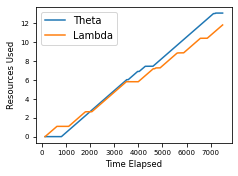

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

start_time = results['time_created'].min()
results.sort_values('time_result_received', inplace=True)
ax.plot(results['time_result_received'] - start_time, results['theta_usage'], label='Theta')
ax.plot(results['time_result_received'] - start_time, results['lambda_usage'], label='Lambda')

ax.legend()
ax.set_xlabel('Time Elapsed')
ax.set_ylabel('Resources Used')

## Assess the Optimizer Performance
See the results of a simulation as a function of time

In [ ]:
simulation_results = results.query('task_type == "simulation" and success').copy()

In [ ]:
simulation_results['ip'] = simulation_results['task_info'].apply(lambda x: x['ip']['xtb-vacuum'])

In [ ]:
fig, ax = plt.subplots()

ax.scatter(simulation_results['walltime'] / 3600, simulation_results['ip'])

ax.set_xlabel('Walltime (hr)')
ax.set_ylabel('IP')

ax.set_xlim(0, max(ax.get_xlim()))

Plot IP over cumulative simulation time

In [15]:
simulation_results['cum_runtime'] = simulation_results['time_running'].cumsum()

(0.0, 14.298552897348689)

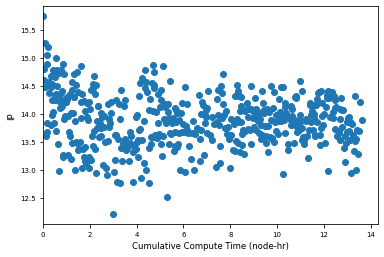

In [16]:
fig, ax = plt.subplots()

ax.scatter(simulation_results['cum_runtime'] / 3600, simulation_results['ip'])

ax.set_xlabel('Cumulative Compute Time (node-hr)')
ax.set_ylabel('IP')

ax.set_xlim(0, max(ax.get_xlim()))

## Run analysis all for experiments
Now that we have these functions, run them for all available experiments

In [30]:
experiment_dirs = [x for x in Path('../runs').iterdir() if x.is_dir() and not x.name.startswith('.')]
print(f'Found {len(experiment_dirs)} experiments')

Found 46 experiments


In [39]:
for experiment in tqdm(experiment_dirs):
    # Clear the old processed results directory
    results_dir = experiment / 'processed-results'
    if results_dir.exists():
        rmtree(results_dir)
    results_dir.mkdir()
    
    # Compute the statistics
    try:
        results = load_results(experiment)
        utilization = get_utilization_over_time(results)
        remove_queue_times(utilization, results)
        compute_cost(utilization, results)

        simulation_results = results.query('task_type == "simulation" and success').copy()
        simulation_results.sort_values('walltime', inplace=True)
        simulation_results['ip'] = simulation_results['task_info'].apply(lambda x: x['ip']['xtb-vacuum'])
    except Exception as e:
        print(f'Processing failed for {experiment}. {e}')
        continue
    
    # Store the results
    results.to_csv(results_dir / 'all-tasks.csv', index=False)
    utilization.to_csv(results_dir / 'utilization.csv', index=False)
    simulation_results.to_csv(results_dir / 'simulation-tasks.csv', index=False)

  0%|          | 0/46 [00:00<?, ?it/s]

Processing failed for ../runs/xtb-N64-n1-8a0d34-14May22-221036. ../runs/xtb-N64-n1-8a0d34-14May22-221036/training-results.json does not exist
Processing failed for ../runs/xtb-N8-n1-a7cdb5-13May22-134650. ../runs/xtb-N8-n1-a7cdb5-13May22-134650/training-results.json does not exist


 50%|█████     | 23/46 [00:16<00:17,  1.33it/s]

Processing failed for ../runs/xtb-N32-n1-2a6c3d-13May22-150954. ../runs/xtb-N32-n1-2a6c3d-13May22-150954/training-results.json does not exist
Processing failed for ../runs/xtb-N16-n1-d489b7-13May22-164954. ../runs/xtb-N16-n1-d489b7-13May22-164954/training-results.json does not exist


 96%|█████████▌| 44/46 [00:36<00:01,  1.08it/s]

Processing failed for ../runs/xtb-N12-n1-bf9940-13May22-143229. ../runs/xtb-N12-n1-bf9940-13May22-143229/training-results.json does not exist


100%|██████████| 46/46 [00:38<00:00,  1.21it/s]


## Match Production Runs to Duplicates
I've repeating the "production runs" several times so we can get better statistics.
This script looks for runs with the same config

In [37]:
for collection in ['prod-runs', 'policy-runs']:
    for runs in Path(collection).iterdir():
        if runs.name.startswith('.') or not runs.is_dir():
            continue

        # Load the original config
        run_config = json.loads(runs.joinpath('run_params.json').read_text())

        # Find all runs that match it
        matches = [
            str(path.absolute().resolve()) for path in experiment_dirs
            if run_config == json.loads(path.joinpath('run_params.json').read_text())
        ]
        print(f'Found {len(matches)} for {runs.name}')

        # Save the duplicate paths
        with open(runs / 'duplicates.json', 'w') as fp:
            json.dump(matches, fp)

Found 1 for 8KNL-8V100-no-retrain
Found 3 for 8KNL-8V100-continuous-no-ps
Found 3 for 8KNL-8V100-continuous-parsl-redis
Found 4 for 8KNL-8V100-continuous
Found 2 for batch_retrain-32
Found 4 for continuous
Found 3 for delay_retrain-32
Found 1 for delay_retrain-64
Found 1 for interleaved-32
Found 1 for interleaved-64
Found 1 for batch_retrain-64
